In [1]:

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-02-14 12:25:46.762628: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 12:25:46.829704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 12:25:46.934807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 12:25:46.935663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds


In [3]:
!pip install imutils

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=f78f0f88fc81581d470ec3a91751e082b2cf7ef0b14cfd595dec3a2feba7c521
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [4]:
from tensorflow.keras.layers import Input, concatenate, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from skimage.transform import resize
import os
import csv
import PIL
import numpy as np
import random
import cv2
import imutils
import tensorflow.keras.backend as K
import tensorflow as tf
import pandas as pd

In [5]:
INIT_LR = 0.0001
EPOCHS = 10
split = 0.8

In [6]:
train_df = pd.read_csv('/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train.csv',header=None)
test = pd.read_csv('/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_test.csv',header=None).rename(columns={0:'image', 1:'depth'})
train_df = train_df.sample(frac=1).reset_index(drop=True).rename(columns={0:'image', 1:'depth'})
train_split = int(len(train_df)*split)


train = train_df[:train_split]
validation = train_df[train_split:]
len(train), len(validation)

(40550, 10138)

In [7]:
import os 
os.chdir('/kaggle/input/nyu-depth-v2/nyu_data/')

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, dataframe, batch_size, shuffle=False, dim=(320,240)):
    # for reproducibility
    np.random.seed(43)
    # dataframe containing the subset of image and depth pairs
    self.df = dataframe
    # chosen Height and Width of the RGB image
    self.height, self.width = dim
    # choice of shuffling the data
    self.shuffle = shuffle
    self.batch_size = batch_size
    # unique set of RGB images
    self.ids = dataframe['image'].unique()
    # Map the image with depth maps
    self.imgtodpth = dataframe.set_index('image')['depth'].to_dict()
    self.on_epoch_end()

  def __len__(self):
    '''
    Returns the length of dataset.
    '''
    return len(self.df) // self.batch_size

  def on_epoch_end(self):
    '''
    Shuffles the data at the end of every epoch
    '''
    self.indexes = np.arange(len(self.ids))
    if self.shuffle:
      np.random.shuffle(self.indexes)
  
  def __getitem__(self,index):
    '''
    returns the batch of image and depth pairs 
    '''
    # select the batch of pair indexes 
    idxs = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
    # randomly select whether to flip the image
    flip = np.random.choice([True, False])
    # select the image id's for the above indexes
    query_imgs = [self.ids[idx] for idx in idxs]
    # select corresponding depth pair for the image
    target_imgs = [self.imgtodpth[img] for img in query_imgs]
    # preprocess the image 
    processed_query_img = self._preprocess_image(query_imgs, flip)
    # preprocess the depth map
    processed_depth_img = self._preprocess_depth(target_imgs, flip)
    return processed_query_img, processed_depth_img

  def _preprocess_image(self,images, flip):
    '''
    Resize, Normalize and randomly Augments the image set. 
    '''
    # placeholder for storing the processed images
    processed = []
    for img in images:
      # resize the image to 480,640
      resized_img = cv2.resize(cv2.imread(img),(self.width, self.height)).astype(np.float32)
      # normalize the image to {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # finally append each image
      processed.append(scaled_img)
    return np.array(processed)

  def _preprocess_depth(self,images, flip):
    '''
    Resize, Normalize and randomly Augments the depth maps.
    '''
    # placeholder for storing the processed depth maps
    processed = []
    for img in images:
      # resize the depth map to 320x240
      resized_img = cv2.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY),(320,240)).astype(np.float32)
      # normalize it to range {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # add the color channel as cv2 grayscale image doesnt contain color channel but tensorflow expects it
      scaled_img = np.expand_dims(scaled_img, axis=-1)
      # finally append the image
      processed.append(scaled_img)
    return np.array(processed)
    

In [9]:
train_generator = DataGenerator(train, batch_size=8, shuffle=True, dim=(480,640))
val_generator = DataGenerator(validation, batch_size=8, shuffle=False, dim=(480,640))
test_generator = DataGenerator(test, batch_size=16, shuffle=False, dim=(480,640))
print(len(train_generator), len(val_generator), len(test_generator))

5068 1267 40


In [10]:
images,depths = next(iter(val_generator))
print(images.shape, depths.shape)

(8, 480, 640, 3) (8, 240, 320, 1)


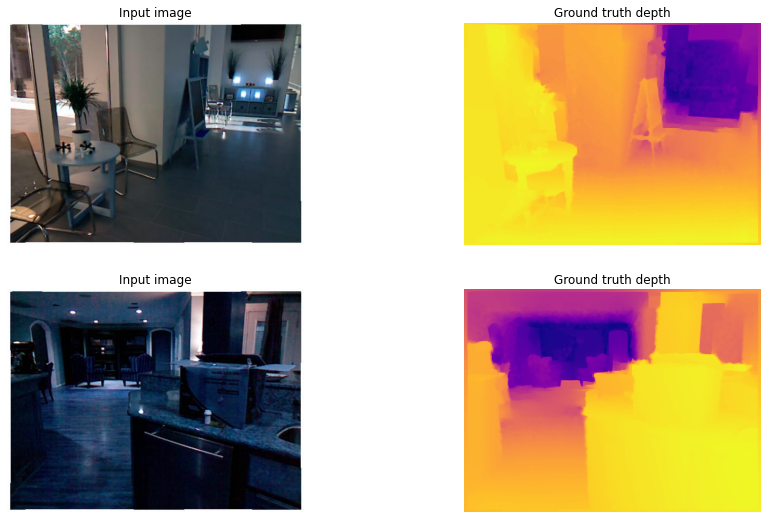

In [11]:
import matplotlib.pyplot as plt
cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,4,2):
  image = images[i]
  depth = depths[i].squeeze(-1)
  plt.subplot(221+i)
  plt.axis('off')
  plt.imshow(image)
  plt.title('Input image')
  plt.subplot(222+i)
  plt.axis('off')
  plt.imshow(depth,cmap=plt.get_cmap(cmap))
  plt.title('Ground truth depth')

In [12]:
from tensorflow.keras.applications import MobileNetV2
# encoder
# Layer name of encoders to be concatenated
names = ['block_13_expand_relu', 'block_6_expand_relu', 'block_3_expand_relu','block_1_expand_relu']
# Transfer learning approach without the classification head
encoder = MobileNetV2(include_top=False, weights='imagenet', input_shape=(480,640,3))
for layer in encoder.layers:
  layer.trainable = True
inputs = encoder.input

x = encoder.output


# bottleneck
conv5 = Conv2D(filters=1664, kernel_size=(1,1), padding='same')(x)
conv5 = LeakyReLU(alpha=0.2)(conv5)

def upsampling_block(input_tensor, n_filters, name, concat_with):
  x = UpSampling2D((2, 2), interpolation='bilinear', name=name)(input_tensor)

  x = concatenate([x, concat_with], axis=3)

  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convB")(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convC")(x)
  x = BatchNormalization()(x)
  return x

# decoder
conv6 = upsampling_block(conv5, 832, "up1", concat_with=encoder.get_layer(names[0]).output)
conv6 = LeakyReLU(alpha=0.2)(conv6)
conv7 = upsampling_block(conv6, 416, "up2", concat_with=encoder.get_layer(names[1]).output)
conv7 = LeakyReLU(alpha=0.2)(conv7)
conv8 = upsampling_block(conv7, 208, "up3", concat_with=encoder.get_layer(names[2]).output)
conv8 = LeakyReLU(alpha=0.2)(conv8)
conv9 = upsampling_block(conv8, 104, "up4", concat_with=encoder.get_layer(names[3]).output)

  # output
o = Conv2D(filters=1, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', name='conv10')(conv9)

model = Model(inputs=inputs, outputs=o)


2023-02-14 12:26:06.225841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 12:26:06.228683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 12:26:06.229765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 12:26:06.231996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 12:26:06.235201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
print("Number of layers in the base model: ", len(encoder.layers))

Number of layers in the base model:  154


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 240, 320, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 240, 320, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 240, 320, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [15]:
!pip install tensorflow_addons

In [16]:
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
def poly_decay(epoch):
  maxEpochs = EPOCHS
  baseLR = INIT_LR
  power = 1.0
  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

opt = tfa.optimizers.AdamW(learning_rate=INIT_LR, weight_decay=1e-6, amsgrad=True)

# custom loss
def depth_loss(y_true, y_pred):
 #Cosine distance loss
  l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
  
  # edge loss for sharp edges
  dy_true, dx_true = tf.image.image_gradients(y_true)
  dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
  
  # structural similarity loss
  l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  # weightage
  w1, w2, w3 = 1.0, 1.0, 0.1
  return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

#custom soft accuracy
def depth_acc(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

checkpoint_path = "/kaggle/working/Checkpoint_Mobile_Net/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 verbose=1)
#
callbacks = [LearningRateScheduler(poly_decay, verbose=1), cp_callback]
     

In [17]:
model.compile(optimizer=opt, loss=depth_loss, metrics=[depth_acc])
     

In [18]:
#checkpoint_path = "/kaggle/working/Checkpoint_Dense_Net/cp.ckpt"
#model.load_weights(checkpoint_path)

In [19]:
# Train the model with the new callback
r = model.fit(train_generator, validation_data=val_generator, epochs=10,callbacks=callbacks)
# Pass callback to training
os.listdir(checkpoint_dir)
# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.


2023-02-14 12:26:18.332344: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.


2023-02-14 12:26:27.240989: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5068/5068 [==============================] - 4110s 807ms/step - loss: 0.1308 - depth_acc: 0.8265 - val_loss: 0.1148 - val_depth_acc: 0.8675

Epoch 00001: val_loss improved from inf to 0.11485, saving model to /kaggle/working/Checkpoint_Mobile_Net/cp.ckpt


2023-02-14 13:34:59.324402: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 9e-05.
5068/5068 [==============================] - 4029s 795ms/step - loss: 0.0969 - depth_acc: 0.8848 - val_loss: 0.0885 - val_depth_acc: 0.8981

Epoch 00002: val_loss improved from 0.11485 to 0.08849, saving model to /kaggle/working/Checkpoint_Mobile_Net/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 8e-05.
5068/5068 [==============================] - 4015s 792ms/step - loss: 0.0853 - depth_acc: 0.9013 - val_loss: 0.0811 - val_depth_acc: 0.9083

Epoch 00003: val_loss improved from 0.08849 to 0.08112, saving model to /kaggle/working/Checkpoint_Mobile_Net/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 7e-05.
5068/5068 [==============================] - 4013s 792ms/step - loss: 0.0779 - depth_acc: 0.9112 - val_loss: 0.0762 - val_depth_acc: 0.9153

Epoch 00004: val_loss improved from 0.08112 to 0.07617, saving model to /kaggle/working/Checkpoint_Mobile_Net/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/10

Epoch 00005: LearningRateScheduler setting learning rate to 6e-05.
5068/5068 [==============================] - 4014s 792ms/step - loss: 0.0725 - depth_acc: 0.9193 - val_loss: 0.0727 - val_depth_acc: 0.9271

Epoch 00005: val_loss improved from 0.07617 to 0.07266, saving model to /kaggle/working/Checkpoint_Mobile_Net/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/10

Epoch 00006: LearningRateScheduler setting learning rate to 5e-05.
5068/5068 [==============================] - 4017s 793ms/step - loss: 0.0684 - depth_acc: 0.9267 - val_loss: 0.0676 - val_depth_acc: 0.9303

Epoch 00006: val_loss improved from 0.07266 to 0.06764, saving model to /kaggle/working/Checkpoint_Mobile_Net/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/10

Epoch 00007: LearningRateScheduler setting learning rate to 4e-05.
5068/5068 [==============================] - 4016s 792ms/step - loss: 0.0651 - depth_acc: 0.9318 - val_loss: 0.0651 - val_depth_acc: 0.9320

Epoch 00007: val_loss improved from 0.06764 to 0.06513, saving model to /kaggle/working/Checkpoint_Mobile_Net/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/10

Epoch 00008: LearningRateScheduler setting learning rate to 3.0000000000000008e-05.
5068/5068 [==============================] - 4036s 796ms/step - loss: 0.0623 - depth_acc: 0.9364 - val_loss: 0.0625 - val_depth_acc: 0.9370

Epoch 00008: val_loss improved from 0.06513 to 0.06247, saving model to /kaggle/working/Checkpoint_Mobile_Net/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/10

Epoch 00009: LearningRateScheduler setting learning rate to 1.9999999999999995e-05.
5068/5068 [==============================] - 4043s 798ms/step - loss: 0.0600 - depth_acc: 0.9397 - val_loss: 0.0608 - val_depth_acc: 0.9401

Epoch 00009: val_loss improved from 0.06247 to 0.06085, saving model to /kaggle/working/Checkpoint_Mobile_Net/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/10

Epoch 00010: LearningRateScheduler setting learning rate to 9.999999999999997e-06.
5068/5068 [==============================] - 4017s 793ms/step - loss: 0.0581 - depth_acc: 0.9426 - val_loss: 0.0598 - val_depth_acc: 0.9409

Epoch 00010: val_loss improved from 0.06085 to 0.05981, saving model to /kaggle/working/Checkpoint_Mobile_Net/cp.ckpt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


['cp.ckpt']

In [20]:
model.save('/kaggle/working/Depth_Unet_MobileNet')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


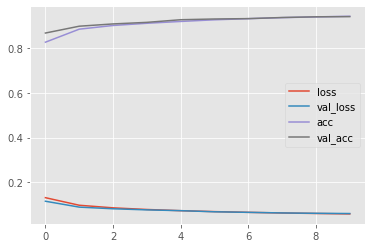

In [21]:
plt.style.use('ggplot')
# e = np.linspace(1, EPOCHS, num=EPOCHS)

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')

plt.plot(r.history['depth_acc'], label='acc')
plt.plot(r.history['val_depth_acc'], label='val_acc')

plt.legend()
plt.show()

In [22]:
model.evaluate(test_generator)

40/40 [==============================] - 37s 865ms/step - loss: 0.1696 - depth_acc: 0.8007


[0.16957584023475647, 0.800737202167511]

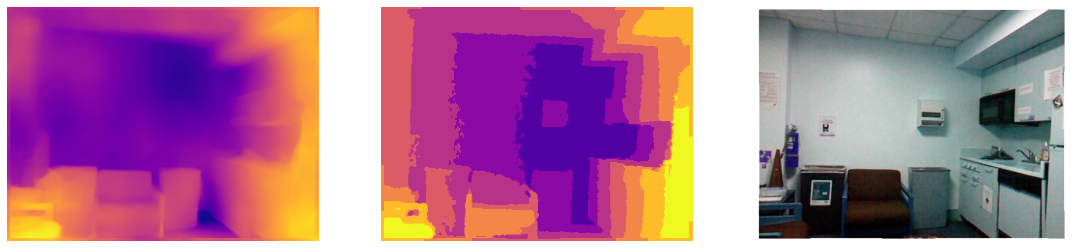

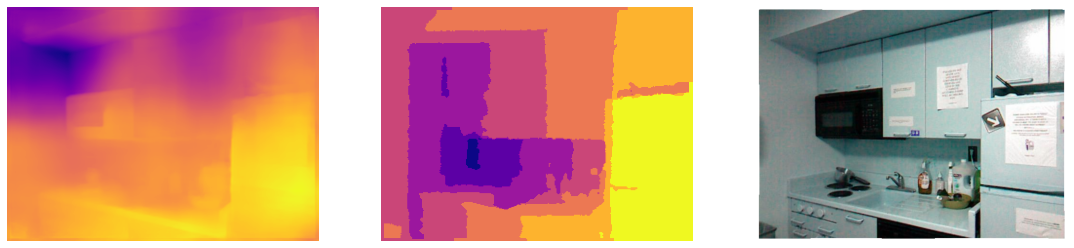

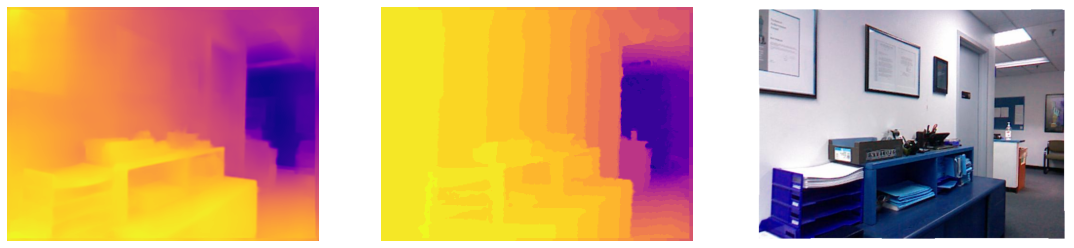

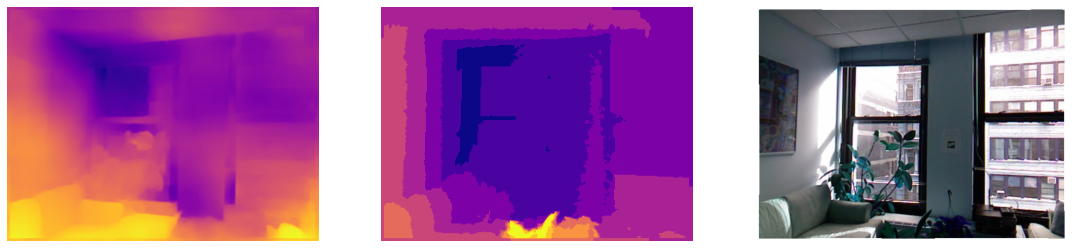

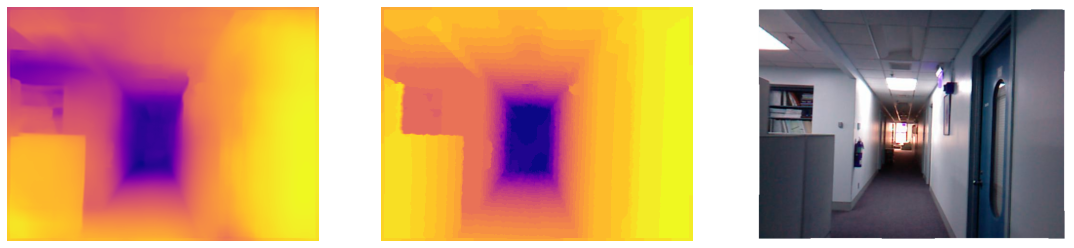

In [23]:
images,labels = next(iter(test_generator))
preds = model.predict(images)
cmap = "plasma_r"


for i in range(5):
  plt.figure(figsize=(19,10))
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)
  plt.subplot(1,3,1)
  plt.axis("off")
  plt.imshow(pred, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,2)
  plt.axis("off")
  img = labels[i]
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,3)
  plt.axis("off")
  img1 = images[i]
  plt.imshow(img1)

  plt.show()